# 量化策略回测框架 (优化性能版)

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
import warnings
from collections import deque

warnings.filterwarnings('ignore', category=UserWarning)

---
## 1. 日志和绘图设置

In [11]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [8]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    优化性能版回测函数，关键改进：
    1. 使用预分配数组替代df.at单元格操作
    2. 优化持仓到期检查逻辑
    3. 减少循环内计算量
    4. 使用numpy向量化操作
    """
    logging.info("🚀 开始执行优化版回测...")
    
    # 使用字典存储结果，最后转换为DataFrame
    n = len(prices)
    results = {
        'position': np.zeros(n, dtype=np.int8),
        'position_count': np.zeros(n, dtype=np.int8),
        'cost_basis': np.zeros(n),
        'transaction_costs': np.zeros(n),
        'net_returns': np.zeros(n),
        'equity_curve': np.full(n, initial_capital)
    }
    
    # 提取价格数组和信号数组
    close_arr = prices.values
    signal_arr = signals.values
    
    # 初始化持仓管理
    active_positions = deque()
    realized_pnl = 0.0
    position_direction = 0
    position_cost = 0.0
    trade_history = []
    capital_per_position = initial_capital / 10
    
    # 预计算索引位置
    indices = prices.index
    
    # 主循环 (优化：减少循环内计算)
    for i in range(1, n):
        current_close = close_arr[i]
        prev_signal = signal_arr[i-1]
        trades_occurred = False
        
        # 1. 处理到期仓位 (优化：只检查队列头部)
        while active_positions:
            pos = active_positions[0]  # 只检查最早仓位
            if i - pos['entry_index'] >= holding_period:
                # 移除并处理到期仓位
                pos = active_positions.popleft()
                exit_price = current_close
                direction = pos['direction']
                quantity = pos['quantity']
                entry_price = pos['entry_price']
                
                # 计算盈亏
                pnl = (exit_price - entry_price) * direction * quantity
                exit_commission = commission_rate * exit_price * quantity
                net_pnl = pnl - exit_commission
                
                # 更新累计已实现盈亏
                realized_pnl += net_pnl
                trades_occurred = True
                
                # 记录交易成本
                results['transaction_costs'][i] += exit_commission
                
                # 记录交易历史
                trade_history.append({
                    'entry_time': indices[pos['entry_index']],
                    'exit_time': indices[i],
                    'direction': direction,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'quantity': quantity,
                    'pnl': pnl,
                    'commission': exit_commission,
                    'net_pnl': net_pnl,
                    'duration': i - pos['entry_index'],
                    'type': 'expired'
                })
            else:
                break  # 最早的仓位未到期，后续仓位也不会到期
        
        # 2. 处理新信号
        if prev_signal != 0:
            # 情况1: 当前无持仓
            if position_direction == 0:
                quantity = capital_per_position / current_close
                new_position = {
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                }
                active_positions.append(new_position)
                position_direction = prev_signal
                position_cost = current_close
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal
            
            # 情况2: 当前有持仓且新信号方向相同
            elif position_direction == prev_signal and len(active_positions) < 10:
                quantity = capital_per_position / current_close
                new_position = {
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                }
                active_positions.append(new_position)
                
                # 更新平均成本 (优化：减少全量计算)
                total_quantity = sum(pos['quantity'] for pos in active_positions)
                position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal
            
            # 情况3: 当前有持仓且新信号方向相反
            elif position_direction != prev_signal and active_positions:
                # 平掉最早的一份持仓
                oldest_position = active_positions.popleft()
                exit_price = current_close
                direction = oldest_position['direction']
                quantity = oldest_position['quantity']
                entry_price = oldest_position['entry_price']
                
                pnl = (exit_price - entry_price) * direction * quantity
                exit_commission = commission_rate * exit_price * quantity
                net_pnl = pnl - exit_commission
                
                realized_pnl += net_pnl
                trades_occurred = True
                results['transaction_costs'][i] += exit_commission
                
                trade_history.append({
                    'entry_time': indices[oldest_position['entry_index']],
                    'exit_time': indices[i],
                    'direction': direction,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'quantity': quantity,
                    'pnl': pnl,
                    'commission': exit_commission,
                    'net_pnl': net_pnl,
                    'duration': i - oldest_position['entry_index'],
                    'type': 'signal'
                })
                
                # 更新持仓状态
                if active_positions:
                    total_quantity = sum(pos['quantity'] for pos in active_positions)
                    position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                else:
                    position_direction = 0
                    position_cost = 0.0
                
                results['position'][i] = position_direction
        
        # 更新持仓状态
        results['position_count'][i] = len(active_positions)
        results['cost_basis'][i] = position_cost
        
        # 更新权益曲线
        current_equity = initial_capital + realized_pnl
        results['equity_curve'][i] = current_equity
        
        # 计算当日净收益率 (优化：向量化计算)
        if i > 1:
            prev_equity = results['equity_curve'][i-1]
            if trades_occurred:
                results['net_returns'][i] = (current_equity - prev_equity) / prev_equity
    
    # 处理回测结束时的未平仓仓位
    if active_positions:
        last_close = close_arr[-1]
        for pos in active_positions:
            exit_price = last_close
            direction = pos['direction']
            quantity = pos['quantity']
            entry_price = pos['entry_price']
            
            pnl = (exit_price - entry_price) * direction * quantity
            exit_commission = commission_rate * exit_price * quantity
            net_pnl = pnl - exit_commission
            
            realized_pnl += net_pnl
            results['transaction_costs'][-1] += exit_commission
            
            trade_history.append({
                'entry_time': indices[pos['entry_index']],
                'exit_time': indices[-1],
                'direction': direction,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'quantity': quantity,
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': n - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
        
        # 更新最终资金曲线
        current_equity = initial_capital + realized_pnl
        results['equity_curve'][-1] = current_equity
        prev_equity = results['equity_curve'][-2] if n > 1 else initial_capital
        results['net_returns'][-1] = (current_equity - prev_equity) / prev_equity
    
    # 向量化计算第一天收益率
    results['net_returns'][0] = (results['equity_curve'][0] - initial_capital) / initial_capital
    
    # 创建DataFrame
    df = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': results['position'],
        'position_count': results['position_count'],
        'cost_basis': results['cost_basis'],
        'transaction_costs': results['transaction_costs'],
        'net_returns': results['net_returns'],
        'equity_curve': results['equity_curve']
    }, index=prices.index)
    
    logging.info("✅ 优化版回测完成")
    return df, pd.DataFrame(trade_history)

In [9]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    优化版性能评估函数
    """
    logging.info("📊 开始评估策略表现...")
    
    df = backtest_results.copy()
    trade_df = trade_history.copy()
    
    # 计算关键指标
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    # 向量化计算回撤
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # 找到最大回撤
    mdd_end = drawdown.idxmax()
    mdd_start = peak[:mdd_end].idxmax()
    
    # 计算年化指标
    total_days = (df.index[-1] - df.index[0]).days
    duration_years = max(total_days / 365.25, 0.001)  # 避免除零
    annualized_return = total_return / duration_years
    
    # 向量化计算收益率
    daily_returns = df['net_returns']
    annualized_volatility = daily_returns.std() * np.sqrt(365.25)
    
    # 使用月度收益率计算风险指标
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()
    sharpe_ratio = monthly_returns.mean() / monthly_returns.std() * np.sqrt(12) if len(monthly_returns) > 1 else 0
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 交易统计 (向量化计算)
    total_trades = len(trade_df)
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]
        
        win_rate = len(winning_trades) / total_trades
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 else float('inf')
        expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
    else:
        win_rate = avg_win = avg_loss = profit_factor = expectancy = 0
    
    # 向量化计算持仓比例
    long_ratio = (df['position'] > 0).mean()
    short_ratio = (df['position'] < 0).mean()
    
    # 计算每周开仓频率
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0
    
    # 计算换手率
    if total_trades > 0:
        trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
        trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
        total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
        avg_net_assets = df['equity_curve'].mean()
        annualized_turnover = (total_turnover / avg_net_assets) / duration_years
    else:
        annualized_turnover = 0
    
    # 信息系数 (向量化计算)
    valid_idx = df['signal'].shift(1).notna() & df['close'].pct_change().shift(-1).notna()
    ic = np.corrcoef(df['signal'].shift(1)[valid_idx], df['close'].pct_change().shift(-1)[valid_idx])[0, 1]
    
    # 计算逐年收益率 (使用groupby向量化)
    yearly_returns = []
    for year, group in df.groupby(df.index.year):
        if len(group) > 1:
            start_equity = group['equity_curve'].iloc[0]
            end_equity = group['equity_curve'].iloc[-1]
            yearly_return = (end_equity - start_equity) / start_equity
            yearly_returns.append((year, yearly_return))
    
    # 理论基准计算 (向量化)
    future_return = (df['close'].shift(-10) - df['close']) / df['close']
    theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)
    
    # ================== 打印完整报告 ==================
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    # 收益指标表格
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "计算结果", "要求", "状态"]
    
    # 评估指标状态
    sharpe_status = "✅ 达标" if sharpe_ratio >= 2.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    calmar_status = "✅ 达标" if calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    expectancy_status = "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    detail_table = [
        ["夏普比率 (Sharpe)", f"{sharpe_ratio:.3%}", "> 2.0", sharpe_status],
        ["卡玛比率 (Calmar)", f"{calmar_ratio:.3%}", "> 5.0", calmar_status],
        ["期望收益 (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 策略方案状态
    print("\n" + Fore.BLUE + Style.BRIGHT + "策略方案评估" + Style.RESET_ALL)
    scheme_table = [
        ["方案一 (夏普 & 卡玛)", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 持仓统计
    print("\n" + Fore.BLUE + Style.BRIGHT + "持仓统计" + Style.RESET_ALL)
    position_table = [
        ["多头持仓占比", f"{long_ratio:.2%}"],
        ["空头持仓占比", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["指标", "值"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 风控与效率指标
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    risk_headers = ["指标名称", "计算结果", "要求", "状态"]
    mdd_status = "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    trade_freq_status = "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    risk_table = [
        ["最大回撤 (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["每周开仓频率", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 综合指标状态
    print("\n" + Fore.YELLOW + Style.BRIGHT + "综合指标评估" + Style.RESET_ALL)
    risk_summary_table = [
        ["综合风控指标", "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["指标", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 详细指标
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["指标名称", "值"]
    detailed_table = [
        [Fore.YELLOW + "与'signal × return'基准的相关性" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["总收益率 (Total Return)", f"{total_return:.3%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.3%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["总盈亏 (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{len(winning_trades)}"],
        ["亏损交易笔数 (Losing Trades)", f"{len(losing_trades)}"],
        ["胜率 (Win Rate)", f"{win_rate:.3%}"],
        ["盈亏比 (Profit Factor)", f"{profit_factor:.3%}"],
        ["平均盈利 (Average Win)", f"{avg_win:.3%}"],
        ["平均亏损 (Average Loss)", f"{avg_loss:.3%}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["最大回撤起始日期", f"{mdd_start}"],
        ["最大回撤结束日期", f"{mdd_end}"],
        ["信息系数 (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 逐年收益率
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["年份", "收益率"], tablefmt="grid", stralign="center", numalign="center"))
        
    # 绘制权益曲线（阶梯状）
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 仅在有交易发生时绘制垂直线条
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # 绘制阶梯状的策略权益曲线
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # 绘制水平线（前一点到当前点）
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # 绘制垂直线（当前点）
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # 绘制最后一段
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # 绘制策略权益曲线主线（阶梯状）
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity (Realized PnL)', color='royalblue', linewidth=2)
    
    # 理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal×return)', color='purple', linestyle='--', alpha=0.7)
    
    # ================== 修改点 2: 修正买入持有曲线的计算方式 ==================
    # 采用与收盘价同步的单利模式，并归一化到初始资本
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0])
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # 设置标题和标签
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

---
## 3. 主程序执行

2025-07-28 14:14:48,923 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-28 14:14:48,932 - INFO - 数据加载成功。
2025-07-28 14:14:48,932 - INFO - 🚀 开始执行优化版回测...
2025-07-28 14:14:49,165 - INFO - ✅ 优化版回测完成
2025-07-28 14:14:49,218 - INFO - 📊 开始评估策略表现...



                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  46.160%   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  19.717%   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |   0.0000   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

策略方案评估
+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

持仓统计
+--------------+-------+
|     指标     |  值   |
+=

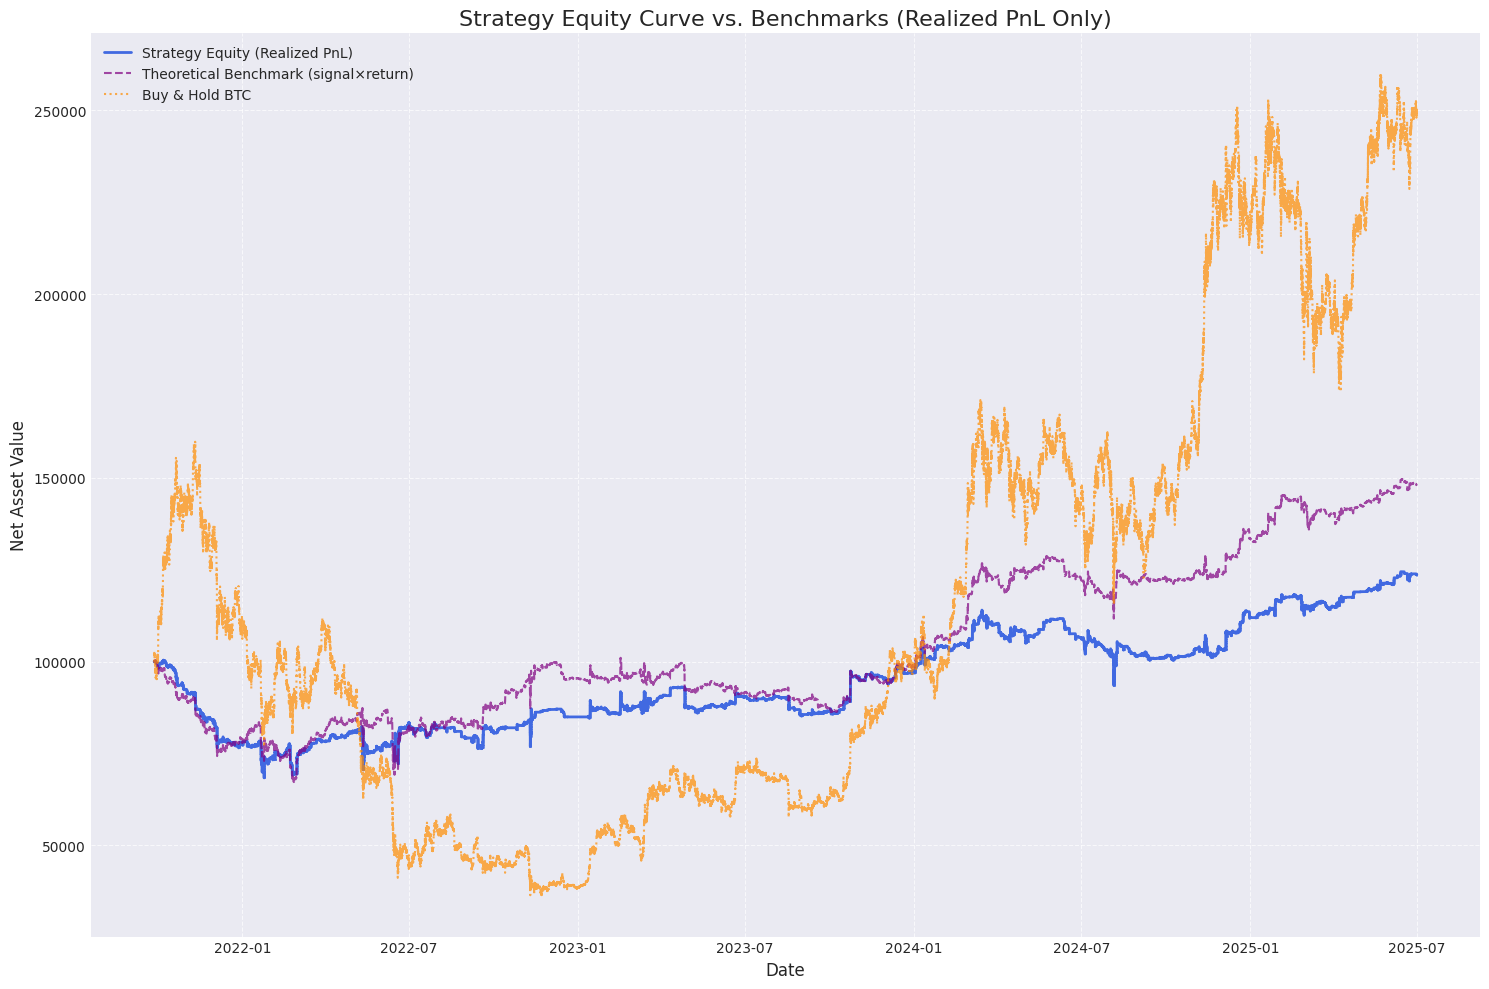

In [10]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info("数据加载成功。")

    except FileNotFoundError:
        logging.error(f"错误: 数据文件未找到于路径 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用基于已实现盈亏的策略) ---
    if data is not None:
        backtest_results, trade_history = run_realized_pnl_backtest(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )

        # --- 4. 性能评估 ---
        evaluate_realized_pnl_performance(
            backtest_results, 
            trade_history,
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败, 回测和评估步骤已跳过。")